In [1]:
!pip install pandas numpy nltk scikit-learn wordcloud seaborn gensim tensorflow imblearn xgboost matplotlib unrar pyunpack more-itertools patool > /dev/null

The system cannot find the path specified.


In [2]:
from nlp_ai_utils import *
from chunks_urls import CHUNKS_URLS
from updating_values import DATA_LIMIT
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already u

True

In [3]:
#Set this to false if you are running this on your local machine, and true if you are running this on google colab
GDRIVE = False

LOCAL_DIR = '../pickle_files/'

In [4]:
#TF_ENABLE_ONEDNN_OPTS = 0
URLS = CHUNKS_URLS
LIMIT = DATA_LIMIT
LARGER_DATASET_PATH = "../larger_dataset"
PREPROCESSED_CHUNKS_PATH = LARGER_DATASET_PATH + "/preprocessed_data_chunks/"
BASE_FILE_NAME = "chunk_"
FILE_FORMAT = ".csv"
ACTUAL_DATA_SHAPE = 6990280
RANDOM_STATE = 42

In [5]:
if not os.path.exists(LARGER_DATASET_PATH):
    os.mkdir(LARGER_DATASET_PATH)
if not os.path.exists(PREPROCESSED_CHUNKS_PATH):
    os.mkdir(PREPROCESSED_CHUNKS_PATH)
get_chunks(URLS,LIMIT,1,BASE_FILE_NAME,PREPROCESSED_CHUNKS_PATH,FILE_FORMAT)

chunk_1 already exists.
chunk_2 already exists.
chunk_3 already exists.
chunk_4 already exists.
chunk_5 already exists.
chunk_6 already exists.


In [6]:
#get all names of downloaded files
all_file_names = get_all_file_names(BASE_FILE_NAME,LIMIT)

In [7]:
#read all chunks into a list
list_dfs = read_chunks(all_file_names,PREPROCESSED_CHUNKS_PATH,FILE_FORMAT)

In [8]:
#concatenate all chunks into a singular df
df = group_up_chunks(list_dfs)

In [9]:
review_data = df[['text', 'stars']].copy()

In [10]:
review_data.reset_index(inplace = True)
review_data.drop(['index'],axis = 1,inplace = True)

In [11]:
review_data.rename(columns = {'text':'full_review_text','stars':'star_rating'}, inplace = True)

In [12]:
review_data['full_review_text'] = pd.Series([str(text) for text in review_data['full_review_text']])

In [13]:
review_data.isnull().sum()
review_data.dropna(inplace = True)

In [14]:
review_data['full_review_text'].replace('', np.nan, inplace=True)
review_data.dropna(inplace = True)

In [15]:
len(review_data['full_review_text'])

699030

## Comparisons

In [16]:
X = review_data['full_review_text']
y = review_data['star_rating']

### Sentiment Polarity

In [17]:
if GDRIVE:
  if os.path.exists("sent_data.pickle"):
      sent_data = pickle.load(open("sent_data.pickle",'rb'))
  else:
      sid = SentimentIntensityAnalyzer()
      sent_polarity_info = [sid.polarity_scores(review) for review in review_data['full_review_text']]
else:
  if os.path.exists(LOCAL_DIR + "sent_data.pickle"):
      sent_data = pickle.load(open(LOCAL_DIR + "sent_data.pickle",'rb'))
  else:
      sid = SentimentIntensityAnalyzer()
      sent_polarity_info = [sid.polarity_scores(review) for review in review_data['full_review_text']]

In [18]:
if GDRIVE:
  if not os.path.exists("sent_data.pickle"):
      review_sentiment = [classify_sentiment(scores) for scores in sent_polarity_info]
      sent_polarity = [extract_sent_polarity(scores) for scores in sent_polarity_info]
      review_data['str_sent'] = review_sentiment
      review_data['sent_polarity'] = sent_polarity
      sentiment_labels = translate_labels(y)
      y_true_sent = encode_sent(sentiment_labels)
      y_pred_sent = encode_sent(review_data['str_sent'])
else:
  if not os.path.exists("../pickle_files/sent_data.pickle"):
    review_sentiment = [classify_sentiment(scores) for scores in sent_polarity_info]
    sent_polarity = [extract_sent_polarity(scores) for scores in sent_polarity_info]
    review_data['str_sent'] = review_sentiment
    review_data['sent_polarity'] = sent_polarity
    sentiment_labels = translate_labels(y)
    y_true_sent = encode_sent(sentiment_labels)
    y_pred_sent = encode_sent(review_data['str_sent'])

In [19]:
if GDRIVE:
  if not os.path.exists("sent_data.pickle"):
      sent_data = review_data[['str_sent', 'sent_polarity']].copy()
      pickle_out = open("sent_data.pickle",'wb')
      pickle.dump(sent_data,pickle_out)
      pickle_out.close()
else:
  if not os.path.exists("../pickle_files/sent_data.pickle"):
    sent_data = review_data[['str_sent', 'sent_polarity']].copy()
    pickle_out = open("../pickle_files/sent_data.pickle",'wb')
    pickle.dump(sent_data,pickle_out)
    pickle_out.close() 

In [20]:
if GDRIVE:
  if not os.path.exists("sent_data.pickle"):
      print(metrics.accuracy_score(y_true_sent,y_pred_sent))
else:
  if not os.path.exists("../pickle_files/sent_data.pickle"):
    print(metrics.accuracy_score(y_true_sent,y_pred_sent))

In [21]:
sentiment_labels = translate_labels(y)
y_true_sent = encode_sent(sentiment_labels)
y_pred_sent = encode_sent(sent_data['str_sent'])
print(metrics.accuracy_score(y_true_sent,y_pred_sent))

0.7532166001459165


### Machine Learning Models

#### Word Embedding

In [22]:
if GDRIVE:
  if not os.path.exists('pickle_files'):
      os.mkdir('pickle_files')
else:
  if not os.path.exists('../pickle_files'):
    os.mkdir('../pickle_files')

In [23]:
count_model = CountVectorizer()

In [24]:
if GDRIVE:
  if not os.path.exists("pickle_files/word2vec_model_sklearn.pickle"):
      print("Creating Embedding From Scratch.")
      word2vec_model_sklearn = count_model.fit_transform(X.apply(lambda x: np.str_(x)))
      pickle_out = open("pickle_files/word2vec_model_sklearn.pickle",'wb')
      pickle.dump(word2vec_model_sklearn,pickle_out)
      pickle_out.close()
  else:
      print("Found Pickle File.")
      word2vec_model_sklearn = pickle.load(open("pickle_files/word2vec_model_sklearn.pickle",'rb'))
else:
  if not os.path.exists("../pickle_files/word2vec_model_sklearn.pickle"):
      print("Creating Embedding From Scratch.")
      word2vec_model_sklearn = count_model.fit_transform(X.apply(lambda x: np.str_(x)))
      pickle_out = open("../pickle_files/word2vec_model_sklearn.pickle",'wb')
      pickle.dump(word2vec_model_sklearn,pickle_out)
      pickle_out.close()
  else:
      print("Found Pickle File.")
      word2vec_model_sklearn = pickle.load(open("../pickle_files/word2vec_model_sklearn.pickle",'rb'))

Creating Embedding From Scratch.


In [25]:
#word2vec_model_sklearn_array = word2vec_model_sklearn.toarray()

In [26]:
x_train,x_test,y_train,y_test = create_train_test_split(word2vec_model_sklearn,y_true_sent,test_size=0.2)

#### Data Resampling

In [27]:
if GDRIVE:
  if not os.path.exists("pickle_files/smote_x_y_train.pickle"):
      random_undersampler = RandomUnderSampler(random_state=RANDOM_STATE)
      x_train,y_train = random_undersampler.fit_resample(x_train,y_train)
else:
  if not os.path.exists("../pickle_files/smote_x_y_train.pickle"):
      random_undersampler = RandomUnderSampler(random_state=RANDOM_STATE)
      x_train,y_train = random_undersampler.fit_resample(x_train,y_train)

In [28]:
if GDRIVE:
  if not os.path.exists("pickle_files/smote_x_y_train.pickle"):
      pickle_out = open("pickle_files/smote_x_y_train.pickle",'wb')
      pickle.dump({'x_train':x_train,'y_train':y_train},pickle_out)
      pickle_out.close()
else:
  if not os.path.exists("../pickle_files/smote_x_y_train.pickle"):
      pickle_out = open("../pickle_files/smote_x_y_train.pickle",'wb')
      pickle.dump({'x_train':x_train,'y_train':y_train},pickle_out)
      pickle_out.close()

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
y_train = scaler.fit_transform(y_train)

#### Training and Results

In [29]:
rf_clf = RandomForestClassifier(n_estimators=25,random_state=RANDOM_STATE)
lr_clf = LogisticRegression(random_state=RANDOM_STATE)
bag_mnnb_clf = BaggingClassifier(base_estimator = MultinomialNB(),n_estimators=25,random_state = RANDOM_STATE)
xgb_clf = XGBClassifier(random_state = RANDOM_STATE)

In [30]:
y_train_xgb,y_test_xgb = adjust_xgb_labels(y_train,y_test)

In [31]:
if GDRIVE:
  if not os.path.exists('pickle_files/rf.pickle'):
    rf_clf.fit(x_train,y_train)
    y_pred_rf = rf_clf.predict(x_test)
    pickle_out = open("pickle_files/rf.pickle",'wb')
    pickle.dump({'rf_clf':rf_clf,'rf_pred':y_pred_rf},pickle_out)
    pickle_out.close()

  if not os.path.exists('pickle_files/lr.pickle'):
    lr_clf.fit(x_train,y_train)
    y_pred_lr = lr_clf.predict(x_test)
    pickle_out = open("pickle_files/lr.pickle",'wb')
    pickle.dump({'lr_clf':lr_clf,'lr_pred':y_pred_lr},pickle_out)
    pickle_out.close()

  if not os.path.exists('pickle_files/bag_mnnb.pickle'):
    bag_mnnb_clf.fit(x_train,y_train)
    y_pred_mnnb = bag_mnnb_clf.predict(x_test)
    pickle_out = open("pickle_files/bag_mnnb.pickle",'wb')
    pickle.dump({'bag_mnnb_clf':bag_mnnb_clf,'y_pred_mnnb':y_pred_mnnb},pickle_out)
    pickle_out.close()

  if not os.path.exists('pickle_files/xgb.pickle'):
    xgb_clf.fit(x_train,y_train_xgb)
    y_pred_xgb = xgb_clf.predict(x_test)
    pickle_out = open("pickle_files/xgb.pickle",'wb')
    pickle.dump({'xgb_clf':xgb_clf,'xgb_pred':y_pred_xgb},pickle_out)
    pickle_out.close()
else:
  if not os.path.exists('../pickle_files/rf.pickle'):
    rf_clf.fit(x_train,y_train)
    y_pred_rf = rf_clf.predict(x_test)
    pickle_out = open("../pickle_files/rf.pickle",'wb')
    pickle.dump({'rf_clf':rf_clf,'rf_pred':y_pred_rf},pickle_out)
    pickle_out.close()

  if not os.path.exists('../pickle_files/lr.pickle'):
    lr_clf.fit(x_train,y_train)
    y_pred_lr = lr_clf.predict(x_test)
    pickle_out = open("../pickle_files/lr.pickle",'wb')
    pickle.dump({'lr_clf':lr_clf,'lr_pred':y_pred_lr},pickle_out)
    pickle_out.close()

  if not os.path.exists('../pickle_files/bag_mnnb.pickle'):
    bag_mnnb_clf.fit(x_train,y_train)
    y_pred_mnnb = bag_mnnb_clf.predict(x_test)
    pickle_out = open("../pickle_files/bag_mnnb.pickle",'wb')
    pickle.dump({'bag_mnnb_clf':bag_mnnb_clf,'y_pred_mnnb':y_pred_mnnb},pickle_out)
    pickle_out.close()

  if not os.path.exists('../pickle_files/xgb.pickle'):
    xgb_clf.fit(x_train,y_train_xgb)
    y_pred_xgb = xgb_clf.predict(x_test)
    pickle_out = open("../pickle_files/xgb.pickle",'wb')
    pickle.dump({'xgb_clf':xgb_clf,'xgb_pred':y_pred_xgb},pickle_out)
    pickle_out.close() 

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


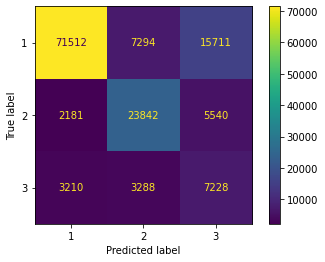

ROC/AUC for each class: 

{1: 0.8187845522901055, 2: 0.8288083072789042, 3: 0.6790200781234398}


Classification Report = 
                precision    recall  f1-score   support

           1       0.93      0.76      0.83     94517
           2       0.69      0.76      0.72     31563
           3       0.25      0.53      0.34     13726

    accuracy                           0.73    139806
   macro avg       0.63      0.68      0.63    139806
weighted avg       0.81      0.73      0.76    139806



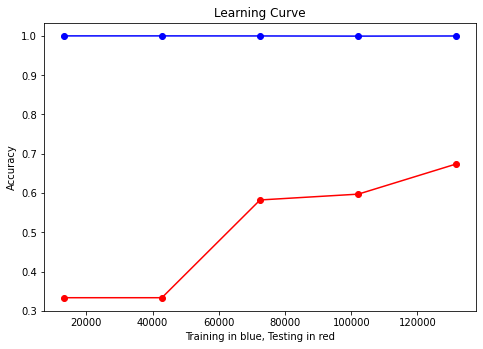

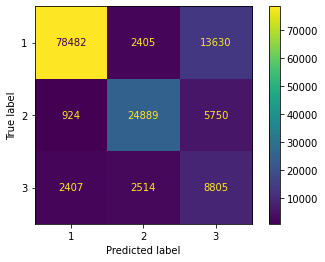

ROC/AUC for each class: 

{1: 0.8783990555534975, 2: 0.8715529185840747, 3: 0.7438856936999774}


Classification Report = 
                precision    recall  f1-score   support

           1       0.96      0.83      0.89     94517
           2       0.83      0.79      0.81     31563
           3       0.31      0.64      0.42     13726

    accuracy                           0.80    139806
   macro avg       0.70      0.75      0.71    139806
weighted avg       0.87      0.80      0.83    139806



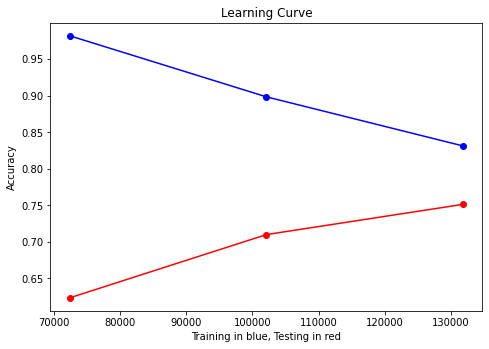

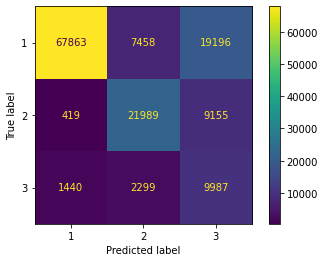

ROC/AUC for each class: 

{1: 0.8384751627605974, 2: 0.8032651868340432, 3: 0.7513660478492779}


Classification Report = 
                precision    recall  f1-score   support

           1       0.97      0.72      0.83     94517
           2       0.69      0.70      0.69     31563
           3       0.26      0.73      0.38     13726

    accuracy                           0.71    139806
   macro avg       0.64      0.71      0.63    139806
weighted avg       0.84      0.71      0.75    139806



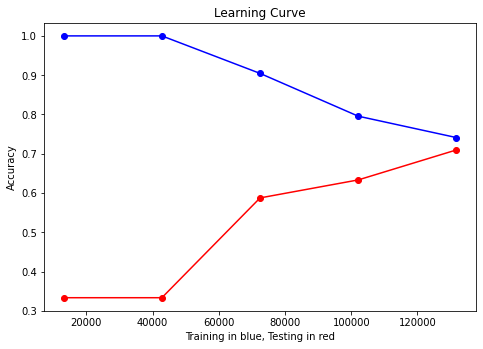

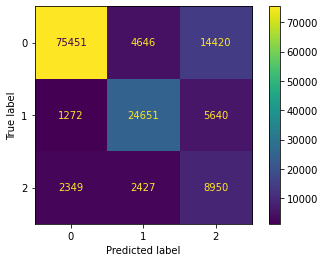

ROC/AUC for each class: 

{0: 0.8591632425198409, 1: 0.8578328461876407, 2: 0.7464709398629155}


Classification Report = 
                precision    recall  f1-score   support

           0       0.95      0.80      0.87     94517
           1       0.78      0.78      0.78     31563
           2       0.31      0.65      0.42     13726

    accuracy                           0.78    139806
   macro avg       0.68      0.74      0.69    139806
weighted avg       0.85      0.78      0.80    139806



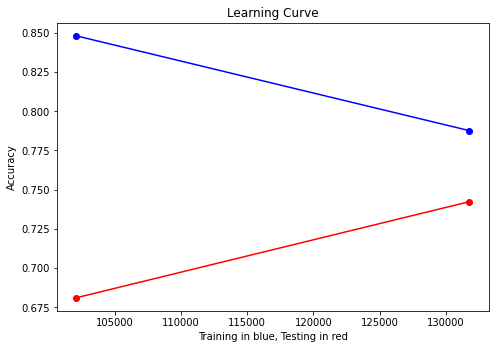

In [32]:
show_metrics('rf',rf_clf,x_test,y_test,y_pred_rf,x_train,y_train,5)
show_metrics('lr',lr_clf,x_test,y_test,y_pred_lr,x_train,y_train,5)
show_metrics('bag_mnnb',bag_mnnb_clf,x_test,y_test,y_pred_mnnb,x_train,y_train,5)
show_metrics('xgb',xgb_clf,x_test,y_test_xgb,y_pred_xgb,x_train,y_train_xgb,5)